In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams
import seaborn as sns
rcParams['figure.figsize'] = 11,10

link = '../Datasets/diabetes.csv'

In [2]:
df = pd.read_csv(link)

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([
('imputer', Imputer(strategy="median")),
('std_scaler', StandardScaler()),
])

In [7]:
matrix = df.corr()

In [8]:
matrix['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

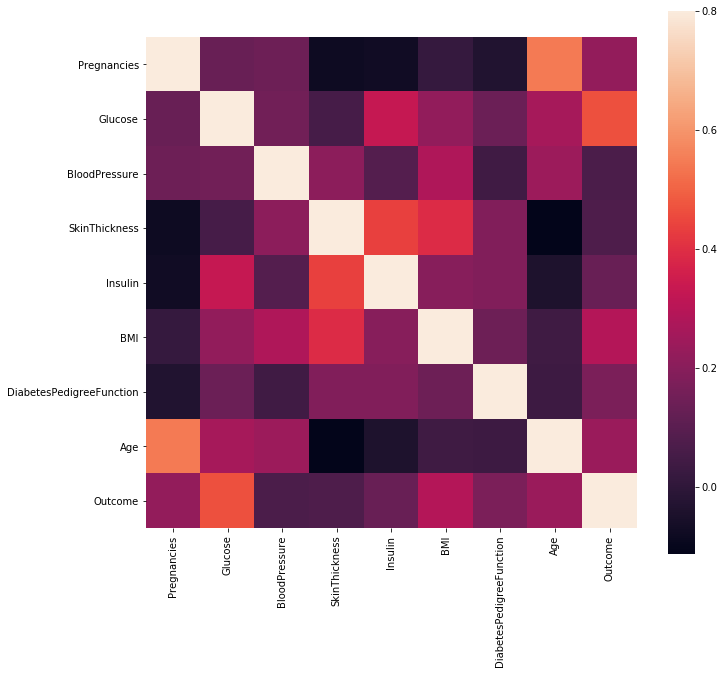

In [9]:
sns.heatmap(matrix, vmax=0.8, square=True)

In [10]:
columns = df.columns.tolist()

columns = [c for c in columns if c not in ['Outcome']]

In [11]:
target = "Outcome"
X = df[columns]  #training set
y = df[target]   #labels
X = pipe.fit_transform(X)

In [12]:
X.shape

(768, 8)

In [13]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [26]:
good = df[df['Outcome'] == 0]
bad = df[df['Outcome'] == 1]
outlier_fraction =  len(bad) / float(len(good))
outlier_fraction = 0.5

In [27]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier

In [28]:
classifiers = {
               'Local Outlier Factor': LocalOutlierFactor(n_neighbors=20, contamination=outlier_fraction, algorithm='auto', leaf_size=30, metric='minkowski'),
               'Support Vector Machine': OneClassSVM(kernel='rbf', degree=3, gamma= 0.1, nu=0.05, max_iter=-1),
               'Decision Tree Classifier':DecisionTreeClassifier(),
               'Isolation Forest': IsolationForest(max_samples=len(X), contamination=outlier_fraction, random_state=1, verbose=0),
               'Ada Boost Classifier':AdaBoostClassifier(),
               'Random Forest Classifier':RandomForestClassifier(), 
               'KNeighbors Classifier': KNeighborsClassifier(3)
               
              }

In [30]:
classifier_accuracy = {}
n_outliers = len(bad)

for i, (clf_name, clf) in enumerate(classifiers.items()):
   
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        y_pred[y_pred ==1]=0
        y_pred[y_pred ==-1]=1
        n_errors = (y_pred !=y).sum()
        print('{}:{}'.format(clf_name,n_errors))
        print('Accuracy Score:',accuracy_score(y, y_pred))
        print(classification_report(y, y_pred))
        classifier_accuracy.update({clf_name:accuracy_score(y, y_pred)})
    
    
    elif clf_name == 'Support Vector Machine':
        clf.fit(X)
        y_pred = clf.predict(X)
        y_pred[y_pred ==1]=0
        y_pred[y_pred ==-1]=1
        n_errors = (y_pred !=y).sum()
        print('{}:{}'.format(clf_name,n_errors))
        print('Accuracy Score:',accuracy_score(y, y_pred))
        print(classification_report(y, y_pred))
        classifier_accuracy.update({clf_name:accuracy_score(y, y_pred)})
    
    
    elif clf_name == 'Decision Tree Classifier':
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
        clf = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        n_errors = (y_pred !=y_test).sum()
        print('{}:{}'.format(clf_name,n_errors))
        print('Accuracy Score:',accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        classifier_accuracy.update({clf_name:accuracy_score(y_test, y_pred)})
    
    
    elif clf_name == 'Ada Boost Classifier':
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
        clf = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        n_errors = (y_pred !=y_test).sum()
        print('{}:{}'.format(clf_name,n_errors))
        print('Accuracy Score:',accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        classifier_accuracy.update({clf_name:accuracy_score(y_test, y_pred)})

        
    elif clf_name == 'Random Forest Classifier':
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
        clf = DecisionTreeClassifier()
        clf = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        n_errors = (y_pred !=y_test).sum()
        print('{}:{}'.format(clf_name,n_errors))
        print('Accuracy Score:',accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        classifier_accuracy.update({clf_name:accuracy_score(y_test, y_pred)})

    elif clf_name == 'KNeighbors Classifier':
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
        clf = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        n_errors = (y_pred !=y_test).sum()
        print('{}:{}'.format(clf_name,n_errors))
        print('Accuracy Score:',accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        classifier_accuracy.update({clf_name:accuracy_score(y_test, y_pred)})
        
    else:
        clf.fit(X)
        score_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        y_pred[y_pred ==1]=0
        y_pred[y_pred ==-1]=1
        n_errors = (y_pred !=y).sum()
        print('{}:{}'.format(clf_name,n_errors))
        print('Accuracy Score:',accuracy_score(y, y_pred))
        print(classification_report(y, y_pred))
        classifier_accuracy.update({clf_name:accuracy_score(y, y_pred)})
    print('-------------------------------------------------------------')

Local Outlier Factor:328
Accuracy Score: 0.5729166666666666
              precision    recall  f1-score   support

           0       0.72      0.56      0.63       500
           1       0.42      0.60      0.50       268

    accuracy                           0.57       768
   macro avg       0.57      0.58      0.56       768
weighted avg       0.62      0.57      0.58       768

-------------------------------------------------------------
Support Vector Machine:264
Accuracy Score: 0.65625
              precision    recall  f1-score   support

           0       0.66      0.96      0.78       500
           1       0.55      0.09      0.15       268

    accuracy                           0.66       768
   macro avg       0.60      0.52      0.47       768
weighted avg       0.62      0.66      0.56       768

-------------------------------------------------------------
Decision Tree Classifier:47
Accuracy Score: 0.6948051948051948
              precision    recall  f1-score   su

In [31]:
ca = [[a,b] for a,b in classifier_accuracy.items()]
ca = pd.DataFrame(ca, columns=['Classifier','Accuracy'])
ca

,Classifier,Accuracy
0,Local Outlier Factor,0.572917
1,Support Vector Machine,0.656250
2,Decision Tree Classifier,0.694805
3,Isolation Forest,0.619792
4,Ada Boost Classifier,0.792208
5,Random Forest Classifier,0.714286
6,KNeighbors Classifier,0.720779


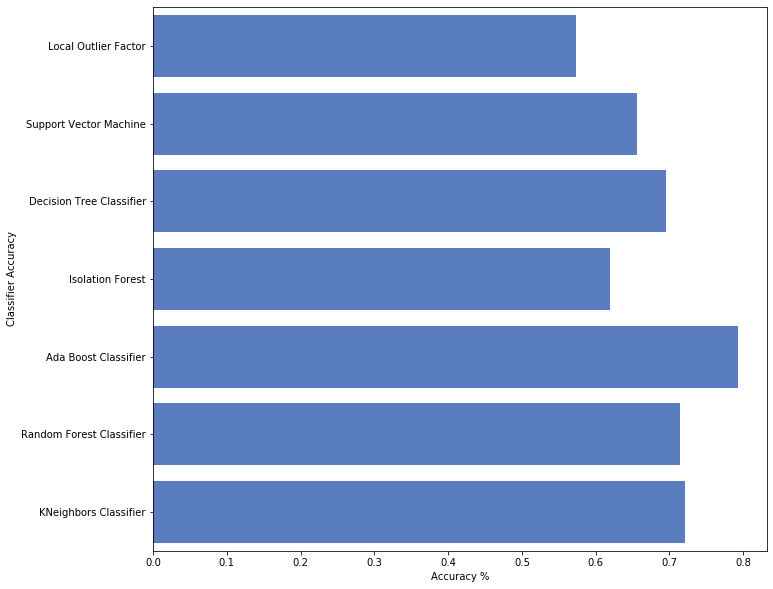

In [33]:
sns.set_color_codes('muted')
sns.barplot(x='Accuracy', y= 'Classifier', data=ca, color='b')
plt.xlabel('Accuracy %')
plt.ylabel('Classifier Accuracy')
plt.show()